In [1]:

from ga_population import *

C:\Users\dg\.conda\envs\diffnet4\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\dg\Documents\python\diffusion-net\experiments\regression_0\ga_regression.py:23: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [9]:
paths = {
    51: Path(r"D:\resynth\run_51_52\run00051_resynth\2025-09-16-15-34-44\opts_and_metadata.pt"),
    42: Path(r"D:\resynth\run_42_43\run00042_resynth\2025-09-11-16-14-13\opts_and_metadata.pt"),
    48: Path(r"D:\resynth\run_48_49\run00048_resynth\2025-09-12-13-05-14\opts_and_metadata.pt"),
    38: Path(r"D:\resynth\run_38_39\run00038_resynth\2025-09-13-10-59-36\opts_and_metadata.pt"),
    20: Path(r"D:\resynth\run_20_21\run00020_resynth\2025-09-14-15-06-07\opts_and_metadata.pt"),
     9: Path(r"D:\resynth\run_09_10\run00009_resynth\2025-09-15-10-17-13\opts_and_metadata.pt"),
}
readers = {run_id: Readers.from_file(f) for run_id, f in paths.items()}

In [10]:
def get_readers(visible_mode: UseVisibleMode | None):
    out = dict()
    tgt = str(visible_mode)
    for run_id, rs in readers.items():
        idx = next(i for i, v in rs.hparams.use_visible.items() if str(v) == tgt)
        out[run_id] = rs[idx]
    return out

# rs = get_readers(UseVisibleMode(False, False))

def get_src_models(visible_mode: UseVisibleMode | None):
    readers = get_readers(visible_mode)
    return {
        run_id: SourceModel.from_reader(reader, cp_data_file=Path(SourceModels.cp_data_files(run_id)))
        for run_id, reader in readers.items()
    }

# _sms = get_src_models(UseVisibleMode(False, False))
_sms = get_src_models(None)
sms = SourceModels(list(_sms.values()))

In [11]:
recache = False
cp_pm_preds = sms.corpus_probe_mesh_preds(pms=pms, cache_file='cp_pm_preds.hdf', recache=recache)
cp_responses = sms.corpus_observed_responses(cp_pm_preds=cp_pm_preds, cache_file='cpm_responses.hdf', recache=recache)

In [18]:
def load_unit_best(model, channel_idx: int, n_best: int):
    meta = model.reader.metadata
    scenes, responses, weights, fit_fns = meta.load_data(weights=meta.weight_error)
    channel = meta.channel[channel_idx]
    unit_responses = responses.iloc[:, channel_idx].sort_values(ascending=False)
    unit_best_scenes = unit_responses.index[:n_best]

    # Load the meshes
    ga_pms = list(ProbeMesh.load_ga_stim(meta.opts.data_dir, scenes.loc[unit_best_scenes]))

    # Present the meshes to the network to get vertex weights
    dataset = GaDataset(
        df=scenes.loc[unit_best_scenes],  # type: ignore
        responses=responses.loc[unit_best_scenes],  # type: ignore
        root_dir=meta.opts.data_file.parent,
        k_eig=meta.k_eig,
        op_cache_dir=meta.opts.data_dir / 'op_cache',
        file_mode=meta.opts.mesh_file_mode,
        weights=meta.weight_error,
        use_visible=meta.use_visible,
        use_color=meta.use_color,
        norm_verts=meta.norm_verts,
        features=meta.input_features,
        augment=None,
    )
    dataloader = DataLoader(dataset, shuffle=False, batch_size=None)
    expt = model.reader.experiment(outputs_at='vertices')
    assert expt.model.outputs_at == 'vertices'
    _ga_obs, ga_weights = expt.predict(dataloader, agg_fn=lambda x: x)
    ga_weights = [VertexWeights(weights=w) for w in ga_weights]

    return ga_pms, ga_weights

In [19]:
def plot_single_channel_vertex_weights(pms: list[ProbeMesh], vertex_weights: list[VertexWeights], channel_idx: int, img_sz=(5, 5), grid_sz=None):
    n_stim = len(pms)
    assert len(vertex_weights) == n_stim
    if grid_sz is None:
        _n = int(np.ceil(np.sqrt(n_stim)))
        grid_sz = (_n, _n)

    nr, nc = grid_sz
    img_sz = np.array(img_sz)


    fig, axs = plt.subplots(nr, nc, figsize=(img_sz[0] * nc, img_sz[1] * nr), squeeze=False)
    axs = axs.reshape(-1)

    for pm, vw, ax in zip(pms, vertex_weights, axs):
        rendered_weights = pm.render(
            weights=vw.weights[:, channel_idx], 
            ground=False, 
            show_scalar_bar=False, 
            window_size=(1024, 1024),
        )
        ax.imshow(rendered_weights)
        ax.axis('off')
    
    for ax in axs[n_stim:]:
        ax.axis('off')
        
    fig.tight_layout()
    return fig

In [6]:
pms = [p.cached() for p in ProbeMeshSpec.defined()]

recache = False
cp_pm_preds = sms.corpus_probe_mesh_preds(pms=pms, cache_file='cp_pm_preds.hdf', recache=recache)
cp_responses = sms.corpus_observed_responses(cp_pm_preds=cp_pm_preds, cache_file='cpm_responses.hdf', recache=recache)

In [12]:
for model_idx, model_ch_idx in cp_responses.columns:
    model = sms[model_idx]
    pass

In [16]:
n_best = 5
ga_pms, ga_vertex_weights = load_unit_best(model, model_ch_idx, n_best)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

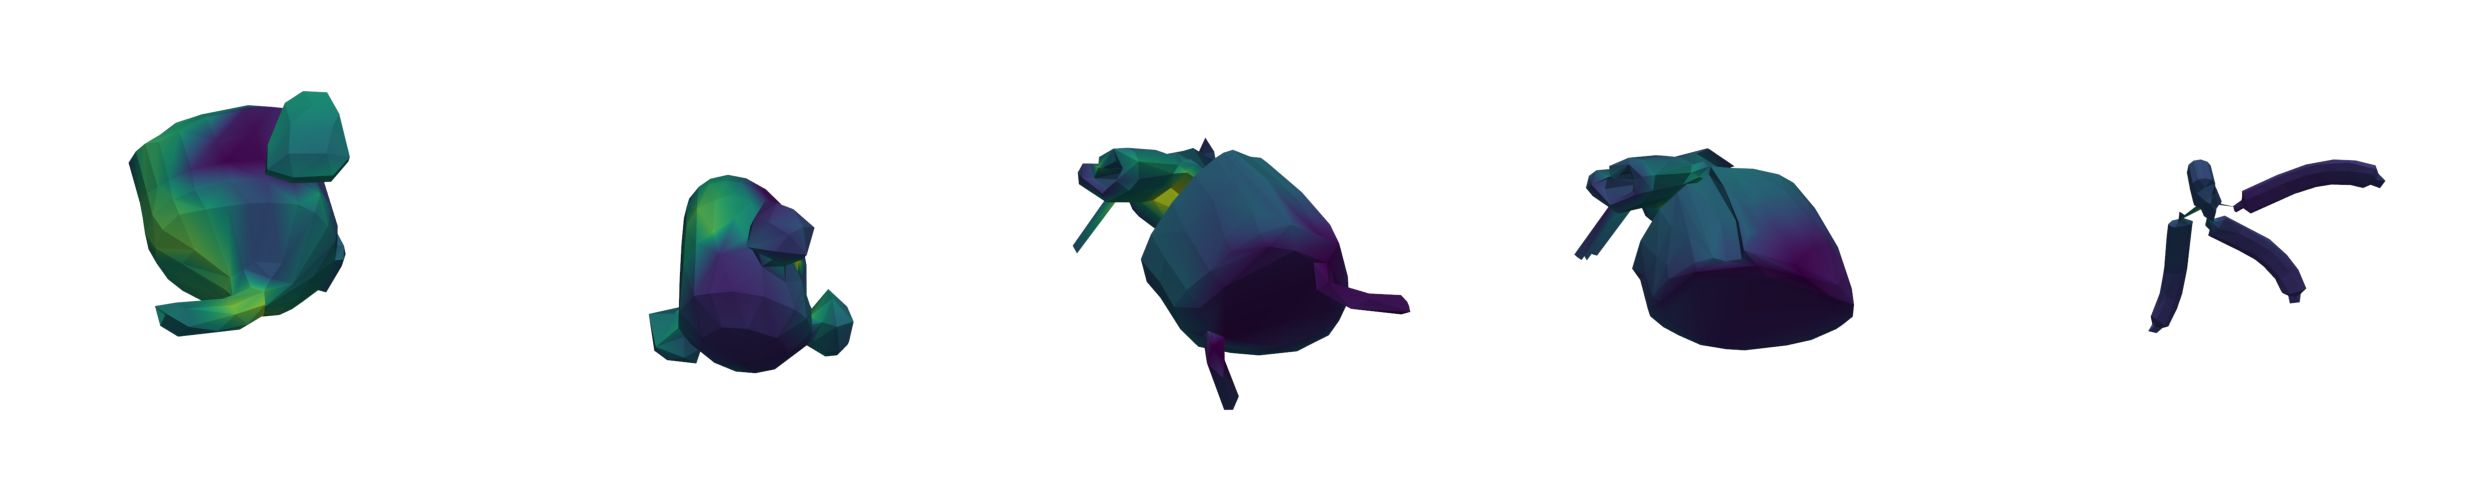

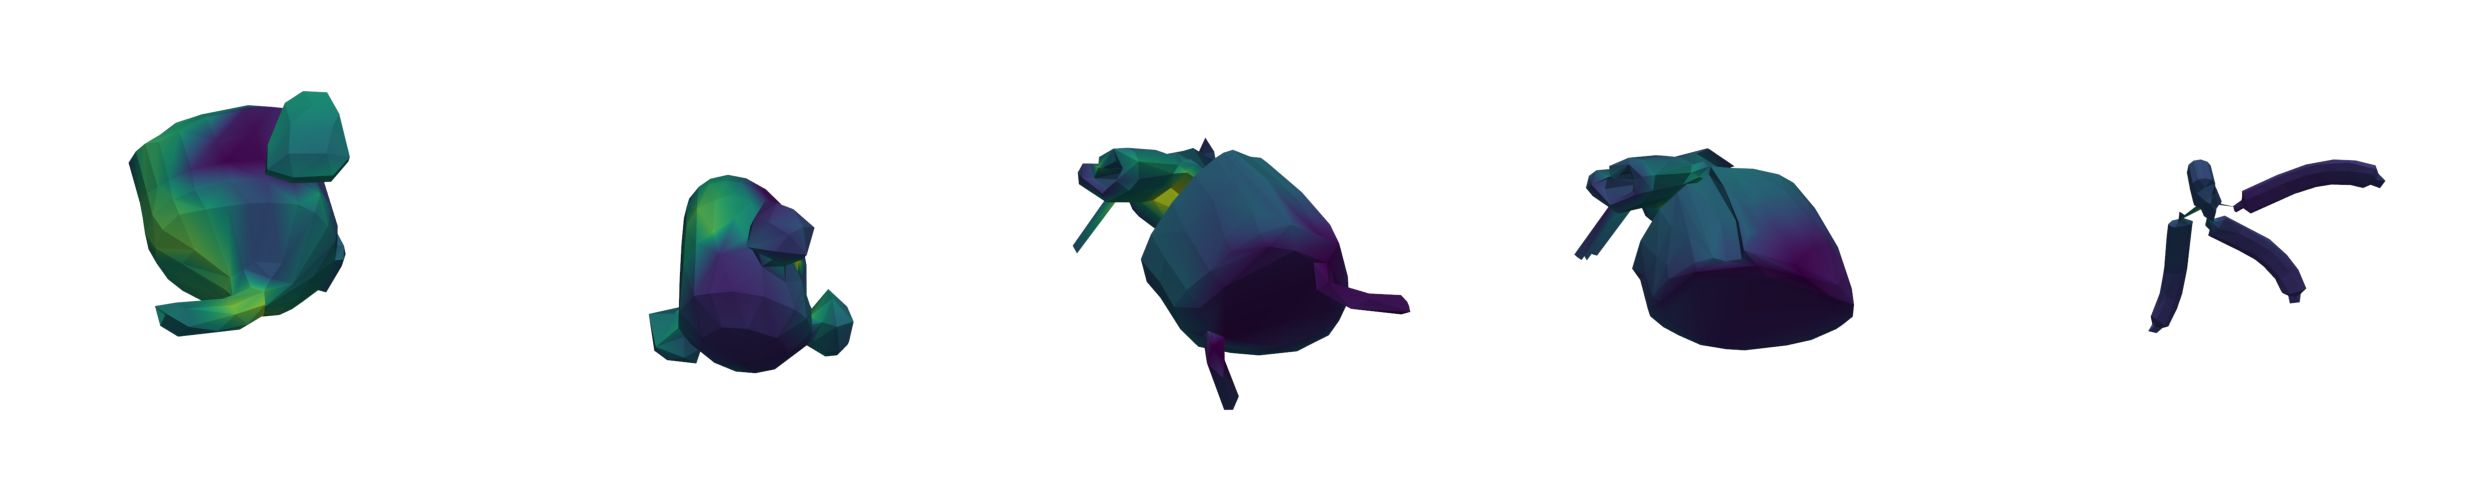

In [20]:
plot_single_channel_vertex_weights(ga_pms, ga_vertex_weights, channel_idx=model_ch_idx, grid_sz=(1, n_best))